In [1]:
from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, plot_roc_curve, roc_curve
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Wrangle


In [2]:
# Pick target
target = 'USE2'

# Load construct dictionary
constructs=pd.read_csv('data/construct_measures.csv', index_col='variable')

# Display the target 
print(target,'-', constructs.loc[target].statement)

USE2 - I use Wikipedia as a platform to develop educational activities with students


In [3]:
def wrangle(df):
    df = df.copy()
    
    # Remap target to binary and drop neutral (3.0) values and null values
    df[target] = df[target].map({5:'Yes', 4: 'Yes', 2: 'No', 1: 'No'})
    df = df.dropna(subset=[target])

    return df.reset_index().drop(columns='index')

# Load and wrangle training data
df = wrangle(pd.read_csv('data/wiki4HE_train.csv',index_col=0))

In [4]:
df.sample(3)

,AGE,GENDER,DOMAIN,PHD,YEARSEXP,UNIVERSITY,UOC_POSITION,OTHER_POSITION,OTHERSTATUS,USERWIKI,...,BI2,INC1,INC2,INC3,INC4,EXP1,EXP2,EXP3,EXP4,EXP5
427,40,1,5.0,1,17.0,1,6.0,1.0,2.0,0.0,...,2.0,4.0,2.0,4.0,3.0,2.0,2.0,3.0,2.0,2.0
420,43,1,1.0,1,20.0,1,6.0,1.0,2.0,0.0,...,1.0,3.0,1.0,4.0,2.0,2.0,2.0,2.0,1.0,2.0
330,56,0,4.0,1,23.0,1,6.0,1.0,2.0,0.0,...,2.0,4.0,2.0,3.0,3.0,4.0,5.0,2.0,1.0,4.0
249,36,0,3.0,1,7.0,1,6.0,1.0,7.0,0.0,...,2.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0
289,50,0,6.0,0,9.0,1,6.0,1.0,7.0,1.0,...,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,4.0,4.0
198,38,0,5.0,0,10.0,1,6.0,2.0,NaN,0.0,...,3.0,4.0,4.0,4.0,4.0,2.0,2.0,2.0,1.0,1.0
63,40,1,6.0,1,15.0,1,2.0,NaN,NaN,0.0,...,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,2.0,5.0
54,42,1,6.0,0,3.0,1,4.0,NaN,NaN,0.0,...,3.0,4.0,4.0,4.0,4.0,2.0,2.0,2.0,1.0,5.0
248,50,0,5.0,1,25.0,1,6.0,1.0,1.0,0.0,...,3.0,3.0,2.0,2.0,4.0,3.0,2.0,3.0,1.0,4.0
508,54,1,3.0,0,2.0,1,6.0,2.0,NaN,0.0,...,3.0,3.0,3.0,4.0,3.0,4.0,4.0,4.0,2.0,3.0


# Split Data

In [5]:
y = df[target]
X = df.drop(columns=df.loc[:,'USE1':'USE5'].columns)

Our model is going to use cross validation so we won't need to utilize a train-validate split.

# Baseline Metrics

In [6]:
print('Baseline Accuracy:', y.value_counts(normalize=True).max())

Baseline Accuracy: 0.8846787479406919


A high baseline accuracy (>70) calculated in this way indicates an imbalanced dataset. In lieu of accuracy we'll use the ROC-AUC score as the baseline metric.  
Thus, the baseline ROC-AUC score is 0.5.

# Build Base Model

In [7]:
model = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    LogisticRegression()
)

# Check Metrics

In [8]:
cv_scores = cross_val_score(model, X, y, cv=5)
print('Cross Validation Score LogisticRegression Model')
print(cv_scores)
print('Mean CV accuracy score:', cv_scores.mean())
print('STD CV accuracy score:', cv_scores.std())

Cross Validation Score LogisticRegression Model
[0.64754098 0.85245902 0.90082645 0.92561983 0.90909091]
Mean CV accuracy score: 0.8471074380165289
STD CV accuracy score: 0.10271055260965856


# Tune Model


In [9]:
params = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': np.arange(0.1, 3, 0.1)
}

cross_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    model,
    param_grid=params,
    scoring='roc_auc',
    cv=cross_validation
)


In [10]:
grid_search.fit(X,y)
y_pr = grid_search.decision_function(X)
roc_auc_score(y, y_pr)

0.9500931098696462

# Communicate Results

## ROC-AUC Curve
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

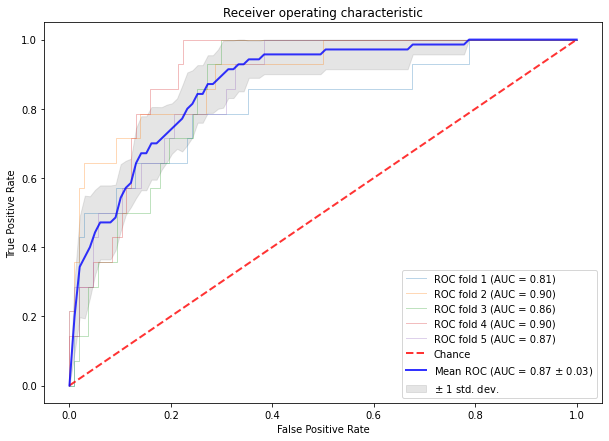

In [11]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
classifier = clone(model)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,7))
for i, (train, test) in enumerate(cross_validation.split(X, y)):
    classifier.fit(X.iloc[train], y.iloc[train])
    viz = plot_roc_curve(classifier, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i+1),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
plt.show()

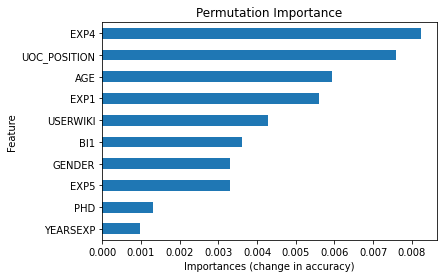

In [12]:
# Permutation importance
perm_imp = permutation_importance(estimator=classifier, X=X, y=y, random_state=42)

data = {
    'importances_mean': perm_imp['importances_mean'],
    'importances_std': perm_imp['importances_std']
}
pi_df = pd.DataFrame(data, index=X.columns).sort_values(by='importances_mean')

pi_df['importances_mean'].tail(10).plot(kind='barh')
plt.xlabel('Importances (change in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation Importance');

In [13]:
print('Features with highest permutation importances:')
print('-'*46)
for i in range(9,-1,-1):
    feature = pi_df.tail(10).index[i]
    print(feature, '-', constructs.loc[feature].statement)

Features with highest permutation importances:
----------------------------------------------
EXP4 - I contribute to Wikipedia (editions, revisions, articles improvement...)
UOC_POSITION - Professor; Associate; Assistant; Lecturer; Instructor; Adjunct
AGE - Age of Professor
EXP1 - I consult Wikipedia for issues related to my field of expertise
USERWIKI - Whether a registered Wikipedia user or not
BI1 - In the future I will recommend the use of Wikipedia to my colleagues and students
GENDER - Male or Female
EXP5 - I use wikis to work with my students
PHD - Has PhD or Not
YEARSEXP - Years of university teaching experience


## Feature Importance
The coefficients with the largest magnitudes affect the target prediction the most, so that is what will be used for the feature importance comparison.

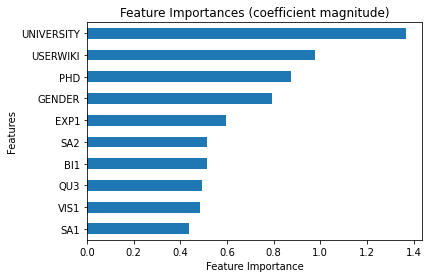

In [14]:
# Feature importances from pipeline
importances = classifier.named_steps['logisticregression'].coef_[0]
feat_imp = pd.Series(data=importances, index=X.columns).map(abs).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances (coefficient magnitude)');

In [15]:
print('Features with highest feature importances:')
print('-'*46)
for i in range(9,-1,-1):
    feature = feat_imp.tail(10).index[i]
    print(feature, '-', constructs.loc[feature].statement)

Features with highest feature importances:
----------------------------------------------
UNIVERSITY - Universitat Oberta de Catalunya (UOC) or Universitat Pompeu Fabra (UPF).
USERWIKI - Whether a registered Wikipedia user or not
PHD - Has PhD or Not
GENDER - Male or Female
EXP1 - I consult Wikipedia for issues related to my field of expertise
SA2 - It is important to publish research results in other media than academic journals or books
BI1 - In the future I will recommend the use of Wikipedia to my colleagues and students
QU3 - Articles in Wikipedia are comprehensive
VIS1 - Wikipedia improves visibility of students' work
SA1 - It is important to share academic content in open platforms


# Test Model on Unseen Data

In [16]:
# Read in test data
test = wrangle(pd.read_csv('data/wiki4HE_test.csv',index_col=0))
# Split data
y_test = test[target]
X_test = test.drop(columns=df.loc[:,'USE1':'USE5'].columns)

## Make predictions

In [17]:
y_pred_prob = grid_search.predict_proba(X_test)[:,1]

## Confusion Matrix

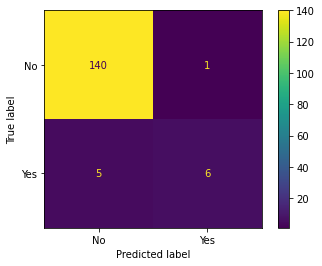

In [18]:
plot_confusion_matrix(
    estimator=grid_search.best_estimator_,
    X=X_test,
    y_true=y_test,
    values_format='.0f'
);

## ROC-AUC

In [20]:
fpr, tpr, thresholds = roc_curve(y_test.map({'Yes':1, 'No':0}), y_pred_prob)

# Results table
roccurve_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
})
roccurve_df.head()

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,1.909594
1,0.000000,0.090909,0.909594
2,0.007092,0.090909,0.867481
3,0.007092,0.545455,0.543304
4,0.014184,0.545455,0.496198


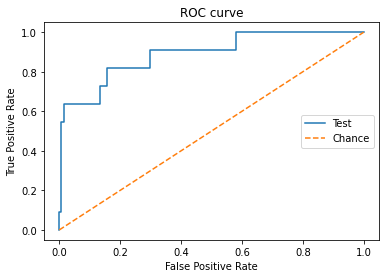

In [21]:
fig, ax = plt.subplots()

ax.plot(fpr, tpr, label='Test')
ax.plot([0,1], ls='--', label='Chance')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='right');

In [19]:
print("Test ROC-AUC Score:", roc_auc_score(y_test.map({'Yes':1,'No':0}), grid_search.predict_proba(X_test)[:,1]))

Test ROC-AUC Score: 0.8891038039974211
